# Analyse data

In [1]:
import pandas as pd
import json
from pathlib import Path
import utils
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import plotly.express as px

In [2]:
df_votum_raw = pd.read_csv(Path('../export/votum.csv'))

# Remove non members (mostly former members who are now in the Regierungsrat)
df_votum_raw = df_votum_raw[df_votum_raw.ismember == True]

# Typecast
df_votum_raw['sitzung_date'] = pd.to_datetime(df_votum_raw['sitzung_date'])

# Remove empty texts
df_votum_raw = df_votum_raw[df_votum_raw.text.notna()]

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_votum_raw['year'] = df_votum_raw['sitzung_date'].dt.year
df_votum_raw['month'] = df_votum_raw['sitzung_date'].dt.month
df_votum_raw['session'] = df_votum_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

## How many times did m/w talk?

In [3]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum_pivot = pd.pivot_table(df_votum, index='session', columns='geschlecht', values='name', aggfunc='count').reset_index()

<AxesSubplot:xlabel='session'>

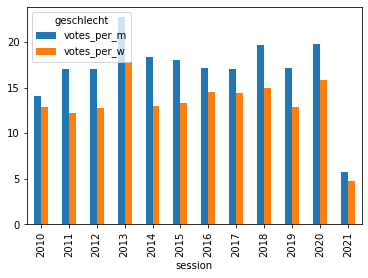

In [4]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df_rat = pd.pivot_table(df, index='year', columns='geschlecht', values='name', aggfunc='count').reset_index()

# Concat
df_res = df_votum_pivot.merge(df_rat, left_on = 'session', right_on = 'year', suffixes=('_v', '_r'))

# Votes per w/m
df_res['votes_per_m'] = round(df_res['m_v'] / df_res['m_r'], 1)
df_res['votes_per_w'] = round(df_res['w_v'] / df_res['w_r'], 1)

df_res.set_index('session', inplace=True)

df_res.drop(columns=['year'], inplace=True)

df_res[['votes_per_m', 'votes_per_w']].plot.bar()

## Unterschiedliche Textlänge?
Erkenntnis: Frauen und Männer reden gleich lange. Wohl wegen beschränkter Redezeit?

In [5]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.reset_index(drop=True)

# Count words
#df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x.split()))
df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x))

df_votum = df_votum.groupby('geschlecht').agg({
    'wordcount': 'sum',
    'name': 'count'
})

df_votum['l'] = round(df_votum['wordcount'] / df_votum['name'])

df_votum

wordcount   name       l
geschlecht                          
m            48438637  24473  1979.0
w            19255566  10024  1921.0

## The Speakers...

<AxesSubplot:ylabel='name'>

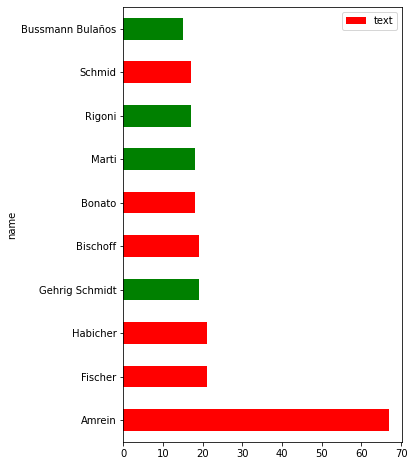

In [6]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session == 2021]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum = df_votum.head(10)

c = list(df_votum['geschlecht'].apply(lambda x: 'red' if x == 'm' else 'green'))
df_votum.plot(kind='barh', x='name', y='text', color=c, figsize=(5, 8))

#df_votum.head()

## Talking parties...

<AxesSubplot:xlabel='partei'>

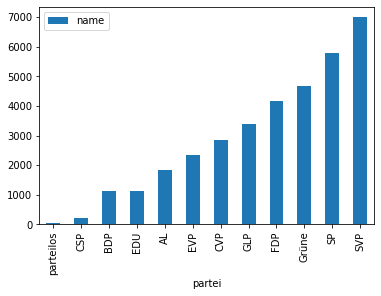

In [7]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).sort_values('name')
df_votum.plot.bar()

In [8]:
x = df.reset_index()
x[(x.year == 2021) & (x.party == 'SVP')].sort_values('name').to_clipboard()

<AxesSubplot:>

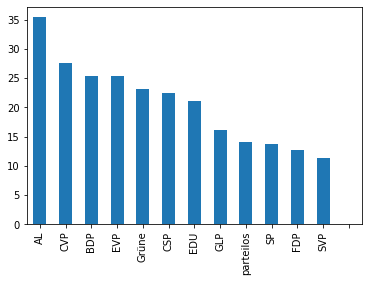

In [9]:
# Relative per strength
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df = pd.pivot_table(df, columns='party', values='name', aggfunc='count').reset_index(drop=True)
df.loc[0, 'name'] = 'members'

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).T.reset_index(drop=True)
df_votum.loc[0, 'name'] = 'votes'

# Combine both datasets, set index and transform
df = pd.concat([df, df_votum])
df = df.set_index('name').T
df = df.fillna(0)

# Calculate Vote per Member
df['per_member'] = round(df['votes'] / df['members'], 1)

df.sort_values('per_member', ascending=False)['per_member'].plot.bar()

In [10]:
df.sort_values('per_member', ascending=False)

name       members   votes  per_member
AL            52.0  1840.0        35.4
CVP          103.0  2836.0        27.5
BDP           44.0  1115.0        25.3
EVP           92.0  2326.0        25.3
Grüne        201.0  4658.0        23.2
CSP           10.0   225.0        22.5
EDU           54.0  1134.0        21.0
GLP          209.0  3383.0        16.2
parteilos      2.0    28.0        14.0
SP           421.0  5776.0        13.7
FDP          328.0  4170.0        12.7
SVP          617.0  6997.0        11.3
               1.0     0.0         0.0

## Wie findet eine Debatte statt?
Dotplots?

In [17]:
records = []
for date in df_votum_raw['sitzung_date'].unique():
    df = df_votum_raw[df_votum_raw.sitzung_date == date].reset_index(drop=True)
    for i, row in df.iterrows():
        t = 'the king' if row['funktion'] in ['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'] else row['geschlecht']
        records.append({
            'sitzung_date': date,
            'i': i,
            'type': t,
            'name': "%s %s" % (row['vorname'], row['name'])
        })    

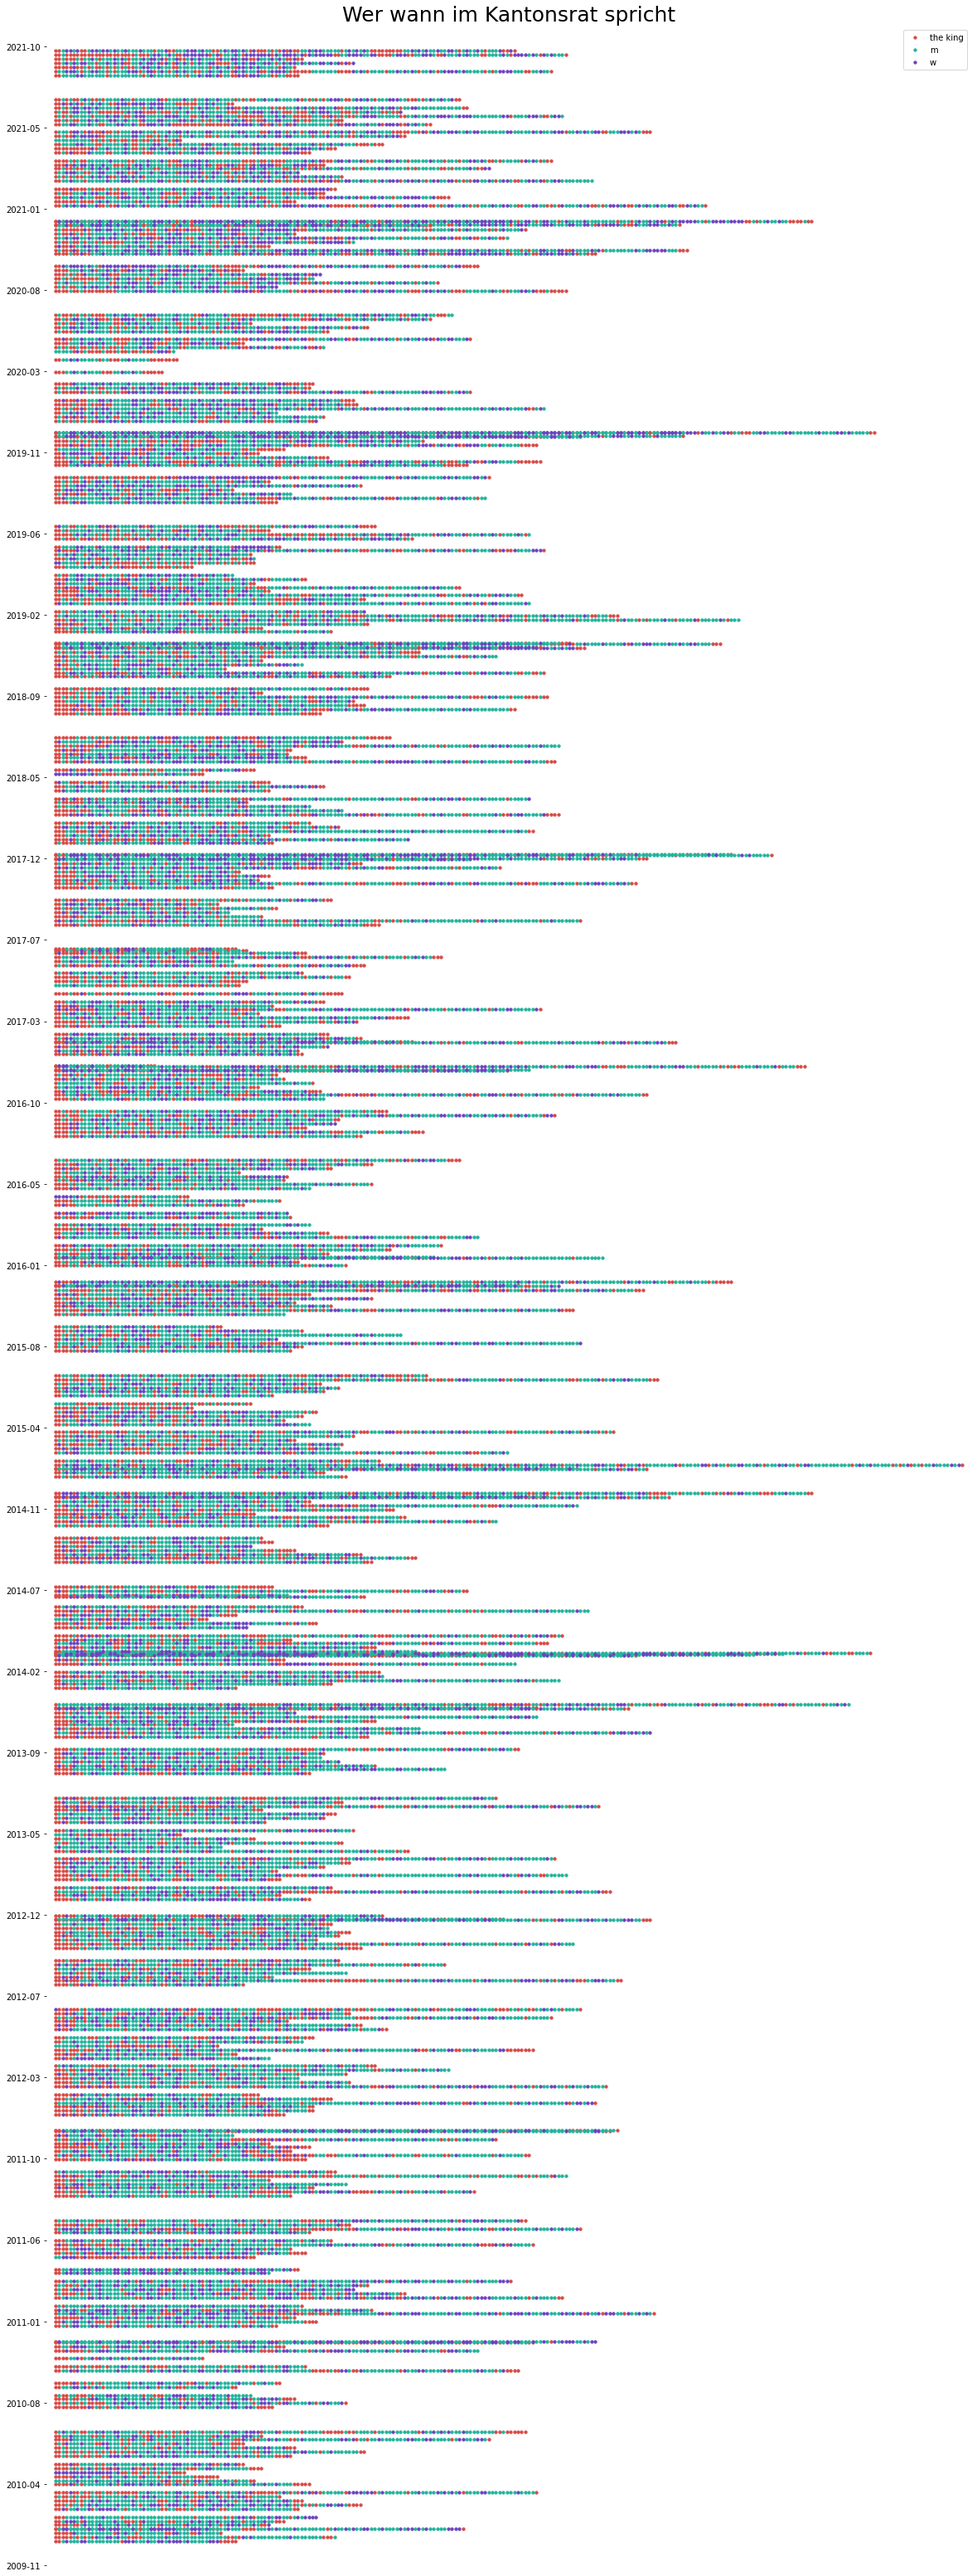

In [25]:
df_sitzung = pd.DataFrame(records)

size_x = 20
fig, ax = plt.subplots(figsize=(size_x, size_x * 1.41 * 2))
ax.margins(0.05)
for t in df_sitzung.type.unique():
    df = df_sitzung[df_sitzung.type == t]
    c = '#d64b47' if t == 'the king' else '#24b39c' if t == 'm' else '#6c43c0'
    ax.plot(df['i'], df['sitzung_date'], marker='o', linestyle='', ms=3.3, label=t, color=c)

ax.legend(numpoints=1, loc='upper right')

ax.yaxis.set_major_locator(mdates.WeekdayLocator(interval=20))
ax.yaxis.set_major_formatter(DateFormatter("%Y-%m"))

plt.title("Wer wann im Kantonsrat spricht", fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.margins(0.01)

#plt.show()
plt.savefig(Path('../export/plots/dotplot.png'), dpi=200, bbox_inches='tight')

#df_sitzung.head()

## The same but interactive

In [24]:
df_sitzung = pd.DataFrame(records)

fig = px.scatter(df_sitzung, x="i", y="sitzung_date", color="type", hover_data=['name'], width=1200, height=2200)

# Change marker size
fig.update_traces(marker=dict(size=4), selector=dict(mode='markers'))

fig.show()

## Who is first speacher after President?